In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


2025-07-19 19:33:44.825283: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 19:33:44.825720: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-19 19:33:44.828196: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-19 19:33:44.835314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752946424.847906   49350 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752946424.85

In [2]:
data = pd.read_csv("data/preprocessed.csv")
m = len(data)
test, cv, train = data.iloc[:round(0.1*m)], data.iloc[round(0.1*m): round(0.2*m)], data.iloc[round(0.2*m):]
x_cols = data.columns.drop(["winner"])
X_test, y_test = test[test["winner"] != 0.5][x_cols].values, test[test["winner"] != 0.5]["winner"].values
X_cv, y_cv = cv[cv["winner"] != 0.5][x_cols].values, cv[cv["winner"] != 0.5]["winner"].values
X_train, y_train = train[x_cols].values, train["winner"].values

In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

In [4]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dense(units = 16, activation="relu", kernel_regularizer=L2(l2= 0.3)),
        Dense(units = 1, activation="sigmoid")
    ]
)


2025-07-19 19:33:47.179296: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
model.compile(
    loss= BinaryCrossentropy(from_logits= True),
    optimizer= Adam()
)
history= model.fit(
    X_train_scaled, y_train,
    validation_data= (X_cv_scaled, y_cv),
    epochs = 100,
    verbose= 1,
    callbacks= [
        tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
    ]
)

Epoch 1/100


/home/luka/Documents/Python_projekti/ufc_pred/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3630 - val_loss: 1.8095
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3712 - val_loss: 0.7708
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7064 - val_loss: 0.6763
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6587 - val_loss: 0.6718
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6526 - val_loss: 0.6748
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6528 - val_loss: 0.6719
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6440 - val_loss: 0.6786
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6440 - val_loss: 0.6779
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6448 - val_loss: 0.6702
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6475 - val_loss: 0.6742
Epoch 11/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6456 - val_loss: 0.6638
Epoch 12/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

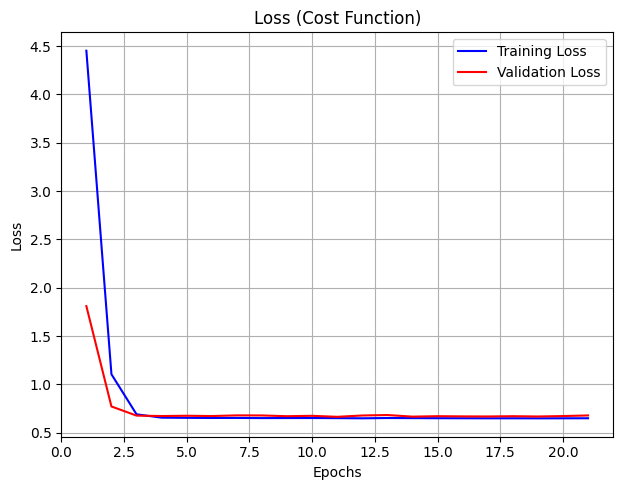

In [6]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss (Cost Function)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Max f1 score = 0.6131147540983607
threshold for max f1 score = 0.6246246246246246
Max acc score = 0.6289424860853432
threshold for max acc score = 0.5005005005005005


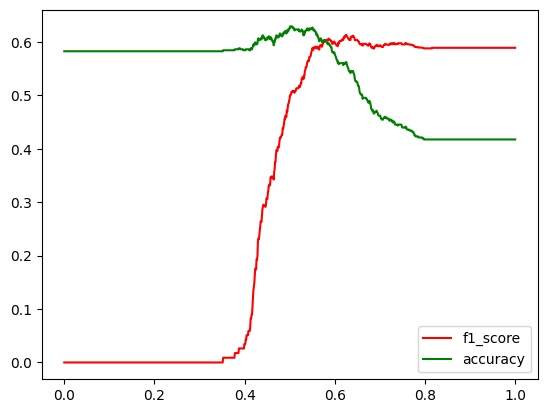

In [7]:
result = model.predict(X_cv_scaled)
result=result.flatten()
thresholds = np.linspace(0,1, num=1000)
f1_values = []
acc_values = []
max_f1 = 0
best_thresh_f1 = 0
max_acc = 0
best_thresh_acc = 0

for thresh in thresholds:
    ypred = np.where(result > thresh, 1, 0)
    f1 = f1_score(y_cv, ypred,pos_label= 0)
    acc = accuracy_score(y_cv,ypred)
    if f1 > max_f1:
        max_f1 = f1
        best_thresh_f1 = thresh
    if acc > max_acc:
        max_acc = acc
        best_thresh_acc = thresh
    f1_values.append(f1)
    acc_values.append(acc)

plt.plot(thresholds, np.array(f1_values),color= "r", label= "f1_score")
plt.plot(thresholds, np.array(acc_values),color= "g", label= "accuracy")
plt.legend()

print(f"Max f1 score = {max_f1}")
print(f"threshold for max f1 score = {best_thresh_f1}")
print(f"Max acc score = {max_acc}")
print(f"threshold for max acc score = {best_thresh_acc}")

In [11]:
accuracy_score(y_test, np.where(model.predict(X_test_scaled).flatten() > 0.5, 1,0))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


0.6128440366972477